In [ ]:
import pandas as pd

import tensorflow as tf
import keras
import numpy as np
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
#from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model

#from keras.utils.training_utils import multi_gpu_model
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras import regularizers

In [ ]:
#########loading data#########
!wget "https://raw.githubusercontent.com/manolofperez/Physalia_MLPopGen/refs/heads/main/2025/Day1/Notebooks/Day1c/mosquito-task2.csv"
!wget "https://raw.githubusercontent.com/manolofperez/Physalia_MLPopGen/refs/heads/main/2025/Day1/Notebooks/Day1c/Mosquito/mosquito-observed.csv"

SuSt = pd.read_csv('./mosquito-task2.csv', sep=",").dropna()
T_split = SuSt["T_split"]
SuSt = SuSt.iloc[:,4:]

emp = pd.read_csv('./mosquito-observed.csv', sep=",")

--2025-03-29 21:32:50--  https://raw.githubusercontent.com/manolofperez/Physalia_MLPopGen/refs/heads/main/2025/Day1/Notebooks/Day1c/mosquito-task2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151838 (148K) [text/plain]
Saving to: ‘mosquito-task2.csv.2’

mosquito-task2.csv. 100%[===================>] 148.28K  --.-KB/s    in 0.003s  

2025-03-29 21:32:50 (55.6 MB/s) - ‘mosquito-task2.csv.2’ saved [151838/151838]

--2025-03-29 21:32:50--  https://raw.githubusercontent.com/manolofperez/Physalia_MLPopGen/refs/heads/main/2025/Day1/Notebooks/Day1c/Mosquito/mosquito-observed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserconten

In [ ]:
emp

,Fst,dxy,segsites1,segsites2,pi1,pi2,tajima1,tajima2
0,0.213414,0.097827,0.3797,0.1013,0.091356,0.035475,0.284715,2.078821


In [ ]:
SuSt

,Fst,dxy,segsites1,segsites2,pi1,pi2,tajima1,tajima2
0,0.345085,0.101800,0.4112,0.0251,0.098128,0.001004,0.252526,-2.972548
1,0.353315,0.103108,0.4069,0.0003,0.098464,0.000076,0.307495,0.293497
2,0.100725,0.094383,0.4019,0.1689,0.094039,0.060180,0.176175,2.181637
3,0.232563,0.096426,0.3940,0.0999,0.096281,0.023796,0.346580,0.244677
4,0.072619,0.104428,0.4271,0.2132,0.102907,0.077670,0.290389,2.313694
...,...,...,...,...,...,...,...,...
995,0.099169,0.093362,0.3988,0.1809,0.095825,0.057207,0.279521,1.524781
996,0.106913,0.103473,0.4123,0.1603,0.101167,0.065803,0.363087,3.069903
997,0.234731,0.108324,0.4256,0.1117,0.101944,0.032330,0.267203,1.084161
998,0.121654,0.096351,0.4032,0.1711,0.095974,0.054928,0.242553,1.603241


In [ ]:
T_split

,T_split
0,6958
1,6381
2,6702
3,7578
4,8077
...,...
995,5198
996,8139
997,6118
998,7893


In [ ]:
#Standardization of the input features with a standard scaler. This is important when working with features tht have different scales.
# The standard score of a sample x is calculated as: z = (x - u) / s
#where u is the mean of the training samples and s is the standard deviation of the training samples.
scale = StandardScaler()
SuSt = scale.fit_transform(SuSt)

In [ ]:
def build_model():
    model = Sequential()
    model.add(Dense(64, input_dim=SuSt.shape[1], activation='elu',
                    kernel_regularizer=regularizers.l1(0.00001)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.summary()
    return model

In [ ]:
from keras import losses

#model initiation
estimator = build_model()

estimator.compile(loss="mean_absolute_percentage_error", optimizer = "Adam")
#early stopping to avoid overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min', restore_best_weights=True)

#display training progress for each completed epoch.
class PrintD(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# maximum number of EPOCHS, ie full training cycles on the whole training dataset (how many times we see the same training set)
EPOCHS = 150

#Training of the Network, with an independent validation set
history = estimator.fit(SuSt[:750], T_split[:750], verbose = 1, epochs=EPOCHS, validation_data=(SuSt[750:], T_split[750:]), batch_size=32, callbacks=[early_stop, PrintD()])

from keras.models import model_from_json

model = estimator.to_json()
# save model
with open('./Trained_SuSt.json','w') as json_file:
    json_file.write(model)

# save weights
estimator.save_weights('./Trained_SuSt' +'.weights.h5')
print('model saved!')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                     │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 99.9909
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 99.9907 - val_loss: 99.9762
Epoch 2/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 99.9602 - val_loss: 99.9328
Epoch 3/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 99.9006 - val_loss: 99.8112
Epoch 4/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 99.7048 - val_loss: 99.5494
Epoch 5/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 99.2788 - val_loss: 98.9353
Epoch 6/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 98.4495 - val_loss: 97.6580
Epoch 7/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 97.1046 - val_loss: 95.3300
Epoch 8/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 93.8635 - val_loss: 90.3204
Epoch 9/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 88.7370 - val_loss: 82.3152
Epoch 10/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 81.9082 - val_loss: 70.1930
Epoch 11/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 69.1636 - va

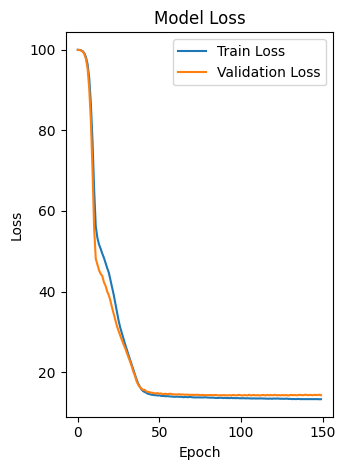

In [ ]:
import matplotlib.pyplot as plt

# Plot loss history
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

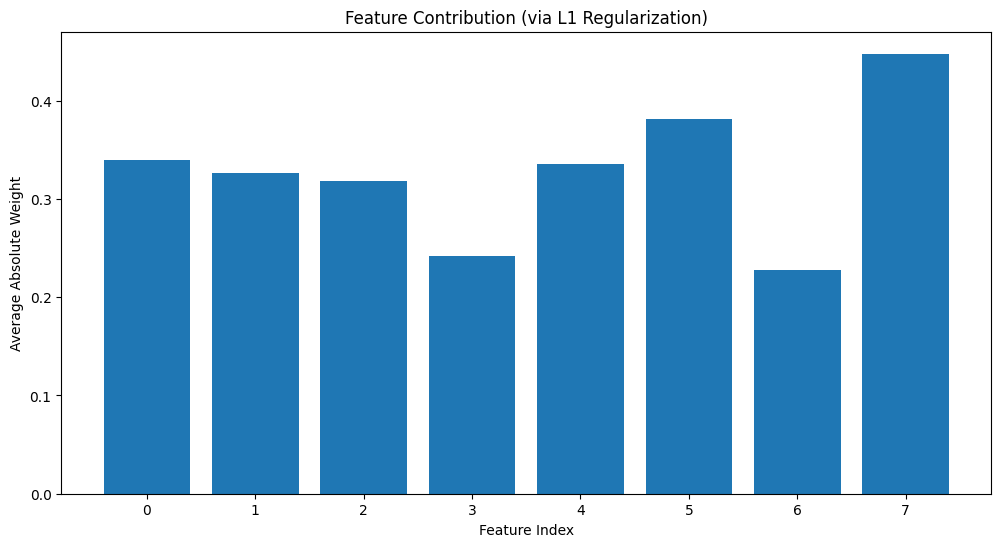

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract weights from the first Dense layer (layer index 0)
weights, biases = estimator.layers[0].get_weights()

# Compute an importance score for each feature (average of absolute weights across neurons)
feature_importance = np.mean(np.abs(weights), axis=1)

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Feature Index')
plt.ylabel('Average Absolute Weight')
plt.title('Feature Contribution (via L1 Regularization)')
plt.show()

In [ ]:
# Print the Summary Statistics names (features) to assign them to feature indexes and compare their contributions.
list(emp)

['Fst', 'dxy', 'segsites1', 'segsites2', 'pi1', 'pi2', 'tajima1', 'tajima2']

In [ ]:
# Now predict T_split for the empirical dataset.
pred = estimator.predict(emp)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


array([[8235.5625]], dtype=float32)